In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim import Adam, SGD
import torchvision
import torchvision.transforms as transforms

import sys, os, math, csv
import argparse
import pandas as pd
import numpy as np

In [2]:
lr=0.01
data='cifar10'
root='./data/'
model='vgg'
model_out='./checkpoint/cifar10_vgg_ProActiv_OneTrainableSigma.pth'
resume = True
batch_size = 100
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
if data == 'cifar10':
    nclass = 10
    img_width = 32
    transform_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)
    
elif data == 'cifar100':
    nclass = 100
    img_width = 32
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.CIFAR100(root=root, train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100(root=root, train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)
    
elif data == 'stl10':
    nclass = 10
    img_width = 32
    transform_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((img_width,img_width)),
        transforms.ToTensor(),
    ])
    transform_test = transforms.Compose([
        transforms.Resize((img_width,img_width)),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.STL10(root=root, split='train', transform=transform_train, target_transform=None, download=True)
    testset = torchvision.datasets.STL10(root=root, split='test', transform=transform_test, target_transform=None, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
if model == 'vgg':
    from models.vgg_dist import VGG_Dist
    net = nn.DataParallel(VGG_Dist(nclass, img_width=img_width).cuda())
    
net

DataParallel(
  (module): VGG_Dist(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    

In [6]:
if resume:
    print(f'==> Resuming from {model_out}')
    net.load_state_dict(torch.load(model_out))

==> Resuming from ./checkpoint/cifar10_vgg_ReLU.pth


In [7]:
cudnn.benchmark = True

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
def test(epoch):
    # track test loss
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            total += targets.size(0)
            correct_tensor = pred.eq(targets.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            
            for i in range(batch_size):
                label = targets.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [10]:
if data == 'cifar10':
    epochs = [1]
elif data == 'cifar100':
    epochs = [3]
elif data == 'stl10':
    epochs = [3]

In [11]:
count = 0

In [12]:
for epoch in epochs:
    optimizer = Adam(net.parameters(), lr=lr)
    for _ in range(epoch):
        test(count)
        count += 1
    lr /= 10

Test Accuracy of airplane: 90% (900/1000)
Test Accuracy of automobile: 94% (944/1000)
Test Accuracy of  bird: 81% (818/1000)
Test Accuracy of   cat: 72% (722/1000)
Test Accuracy of  deer: 88% (883/1000)
Test Accuracy of   dog: 80% (803/1000)
Test Accuracy of  frog: 91% (910/1000)
Test Accuracy of horse: 89% (897/1000)
Test Accuracy of  ship: 92% (923/1000)
Test Accuracy of truck: 90% (903/1000)

Test Accuracy (Overall): 87% (8703/10000)


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

<Figure size 432x288 with 0 Axes>

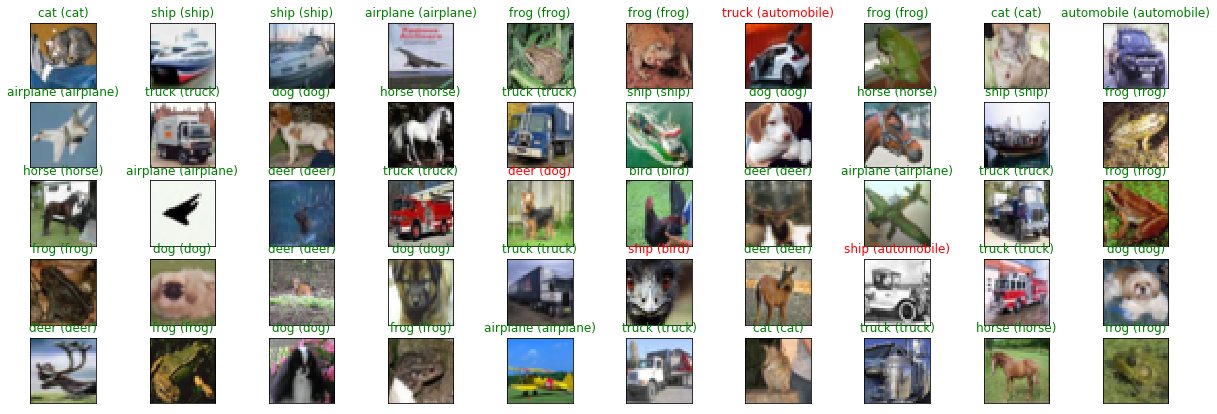

In [15]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()
fig = plt.figure()

output = net(images).cpu()
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(21, 7))
for idx in np.arange(50):
    ax = fig.add_subplot(5, 50/5, idx+1, xticks=[], yticks=[])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    imshow(images[idx])
fig.savefig('resultsProaActiv.png', dpi=fig.dpi)
    

In [2]:
lr=0.01
data='cifar10'
root='./data/'
model='vgg'
model_out='./checkpoint/cifar10_vgg_ReLU.pth'
resume = True
batch_size = 100
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [12]:
for epoch in epochs:
    optimizer = Adam(net.parameters(), lr=lr)
    for _ in range(epoch):
        test(count)
        count += 1
    lr /= 10

Test Accuracy of airplane: 89% (891/1000)
Test Accuracy of automobile: 93% (938/1000)
Test Accuracy of  bird: 78% (781/1000)
Test Accuracy of   cat: 71% (717/1000)
Test Accuracy of  deer: 87% (877/1000)
Test Accuracy of   dog: 78% (783/1000)
Test Accuracy of  frog: 90% (902/1000)
Test Accuracy of horse: 87% (879/1000)
Test Accuracy of  ship: 93% (938/1000)
Test Accuracy of truck: 90% (908/1000)

Test Accuracy (Overall): 86% (8614/10000)


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
#     img = img / 2   # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

ValueError: num must be 1 <= num <= 4, not 5

<Figure size 432x288 with 0 Axes>

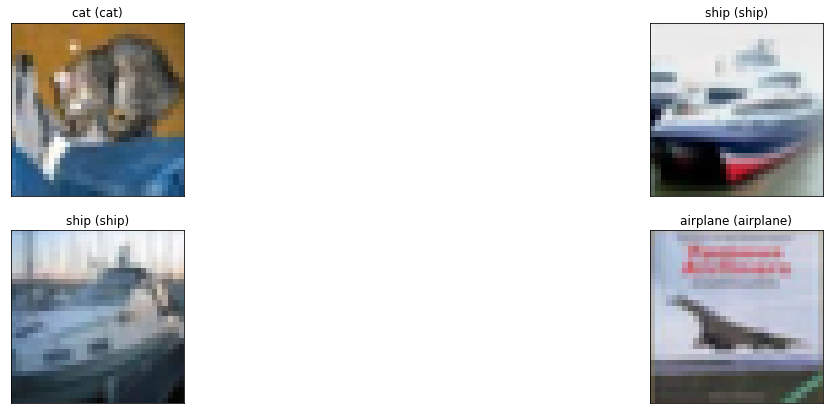

In [36]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()
fig = plt.figure()

output = net(images).cpu()
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(21, 7))
index = []
for idx in np.arange(100):
#     ax = fig.add_subplot(5, 50/5, idx+1, xticks=[], yticks=[])
#     ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
#                  color=("green" if preds[idx]==labels[idx].item() else "red"))
    if preds[idx]!=labels[idx].item():
#         print(idx)
        index.append(idx)
for i in range(len(index)):
    ax = fig.add_subplot(2, 12/6, i+1, xticks=[], yticks=[])
    ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                color = )
    imshow(images[i])
    
fig.savefig('resultsReLU.png', dpi=fig.dpi)    

In [2]:
lr=0.01
data='stl10'
root='./data/'
model='vgg'
model_out='./checkpoint/stl10_vgg_ProActiv_OneTrainableSigma.pth'
resume = True

In [11]:
for epoch in epochs:
    optimizer = Adam(net.parameters(), lr=lr)
    for _ in range(epoch):
        test(count)
        count += 1
    lr /= 10

[TEST] Acc: 62.038
[TEST] Acc: 62.038
[TEST] Acc: 62.038


In [2]:
lr=0.01
data='cifar100'
root='./data/'
model='vgg'
model_out='./checkpoint/cifar100_vgg_ProActiv_OneTrainableSigma.pth'
resume = True

In [11]:
for epoch in epochs:
    optimizer = Adam(net.parameters(), lr=lr)
    for _ in range(epoch):
        test(count)
        count += 1
    lr /= 10

[TEST] Acc: 50.750
[TEST] Acc: 50.750
[TEST] Acc: 50.750
